In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import RobustScaler


C:\Users\TRETEC\AppData\Local\Temp\ipykernel_17076\4156923115.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
TRAIN_INPUT = "data/x_train.csv"
TRAIN_OUTPUT = "data/y_train.csv"
TEST_INPUT = "data/x_test.csv"

In [3]:
x_train = pd.read_csv(TRAIN_INPUT, index_col= 'DELIVERY_START', parse_dates=True)
y_train = pd.read_csv(TRAIN_OUTPUT, index_col= 'DELIVERY_START', parse_dates=True)
x_test = pd.read_csv(TEST_INPUT, index_col= 'DELIVERY_START', parse_dates=True)

In [4]:
#datetime data
x_train.set_index(pd.to_datetime(x_train.index, utc=True), inplace=True)
y_train.set_index(pd.to_datetime(y_train.index, utc=True), inplace=True)
x_test.set_index(pd.to_datetime(x_test.index, utc=True), inplace=True)

## 1. EDA

* Sampling frequency is not always 1h between samples
* ~~Datetime column not in same timezone~~ 
* Training data ranges from 2022-01-01 to 2023-03-29; Testing data ranges from 2023-04-02 to 2023-10-24
* Data is balanced (classification)
* Missing values : most of values from column 'predicted_spot_price'
* High correlation between : nuclear_power_available and coal_power_available, nuclear_power_available and load_forecast

In [5]:
x_test.index.diff().dropna().total_seconds().value_counts()

DELIVERY_START
3600.0     4940
10800.0       1
Name: count, dtype: int64

In [6]:
x_train.index.diff().dropna().total_seconds().value_counts()

DELIVERY_START
3600.0      10595
90000.0         4
144000.0        1
43200.0         1
165600.0        1
262800.0        1
7200.0          1
Name: count, dtype: int64

In [7]:
print(f"Training data : from {x_train.index.min().date()} to {x_train.index.max().date()}")
print(f"Test data : from {x_test.index.min().date()} to {x_test.index.max().date()}")

Training data : from 2022-01-01 to 2023-03-29
Test data : from 2023-04-01 to 2023-10-24


In [8]:
y_train_cls = (y_train>0).astype(int)
100*y_train_cls.value_counts()/y_train.shape[0]

spot_id_delta
1                50.165017
0                49.834983
Name: count, dtype: float64

<Axes: ylabel='DELIVERY_START'>

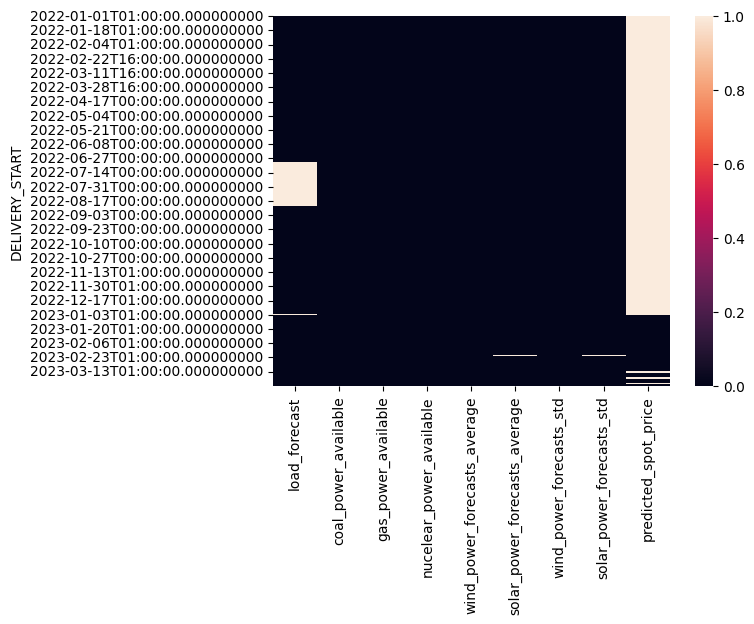

In [9]:
sns.heatmap(x_train.isna())

<Axes: ylabel='DELIVERY_START'>

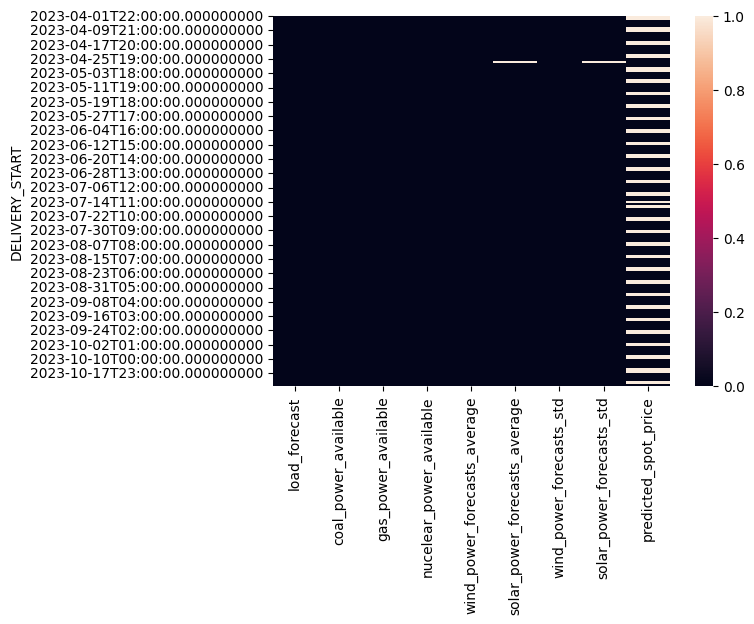

In [10]:
sns.heatmap(x_test.isna())

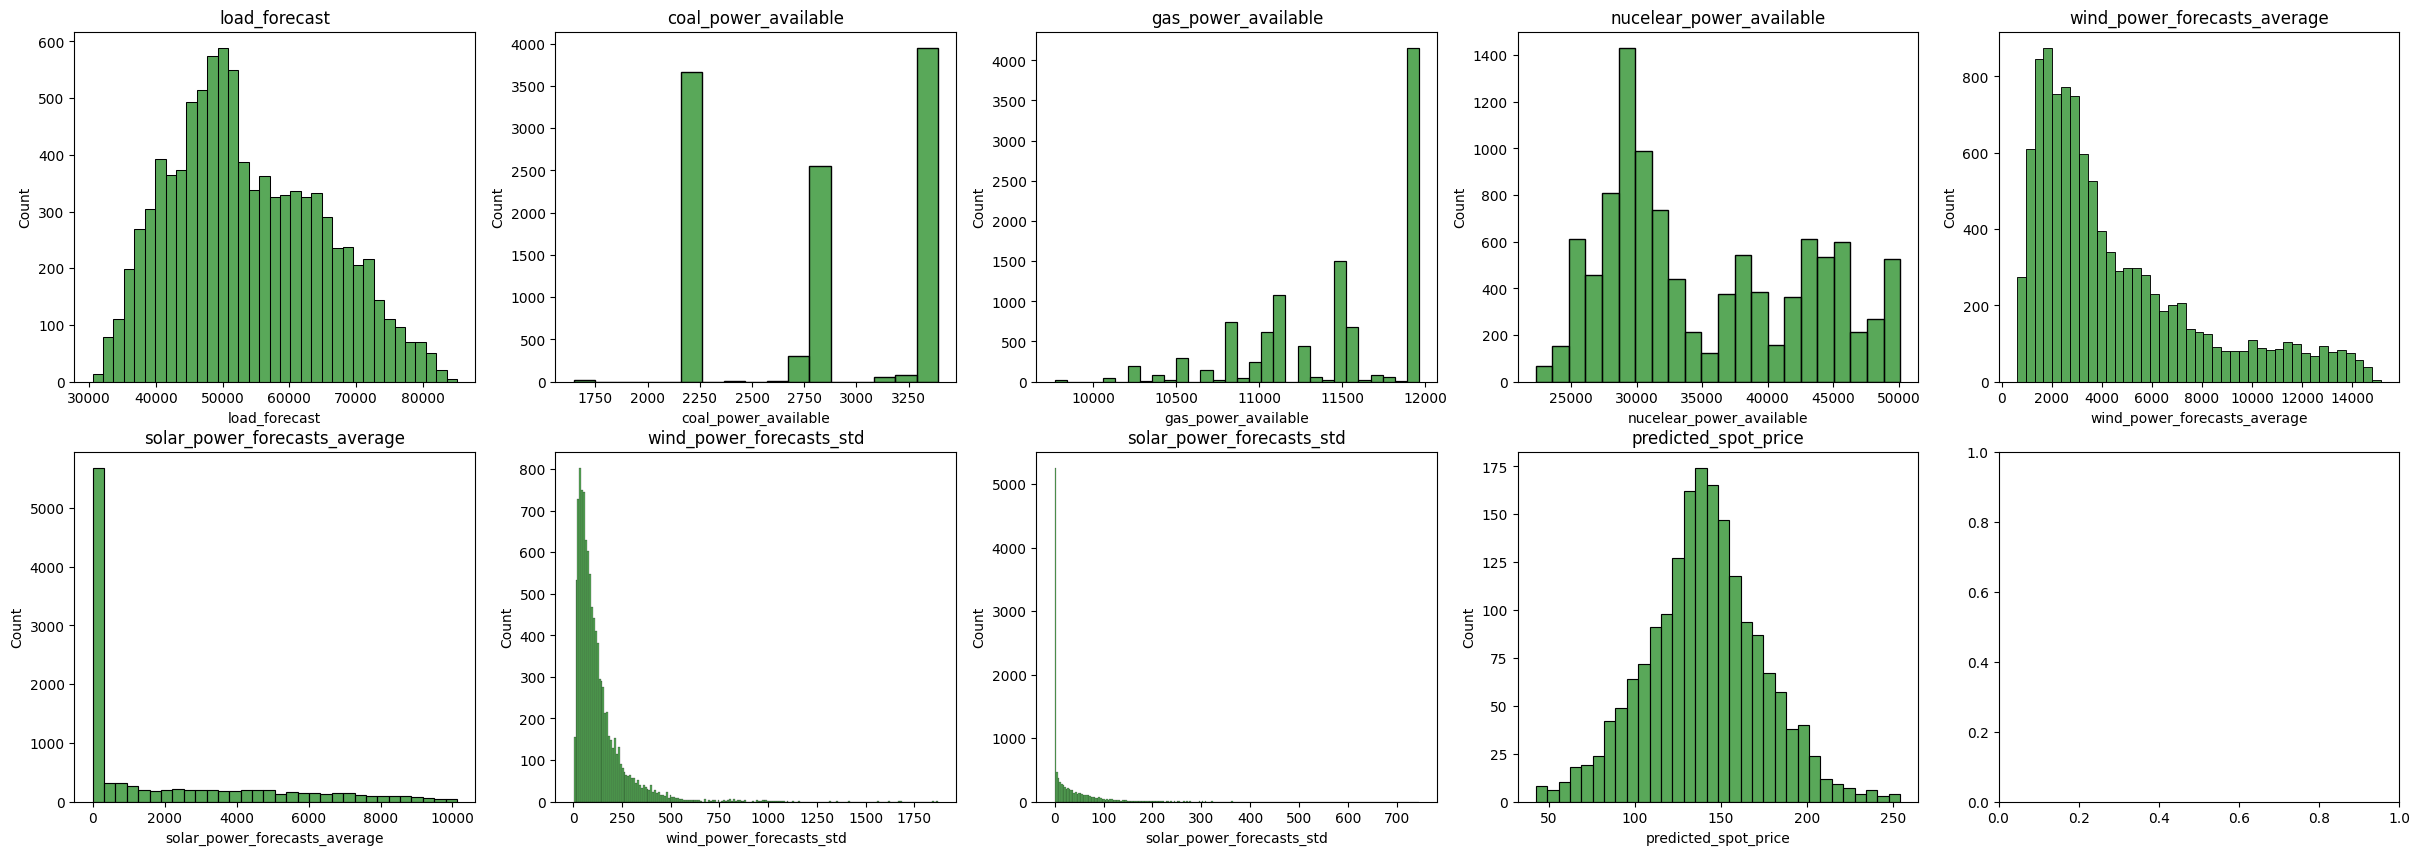

In [11]:
fig, axes = plt.subplots(nrows = 2, ncols = 5)    # axes is 2d array (3x3)
axes = axes.flatten()         # Convert axes to 1d array of length 9
fig.set_size_inches(30, 10)

for ax, col in zip(axes, x_train.columns):
  sns.histplot(x_train[col], ax = ax, color='forestgreen')
  ax.set_title(col)


<Axes: xlabel='DELIVERY_START'>

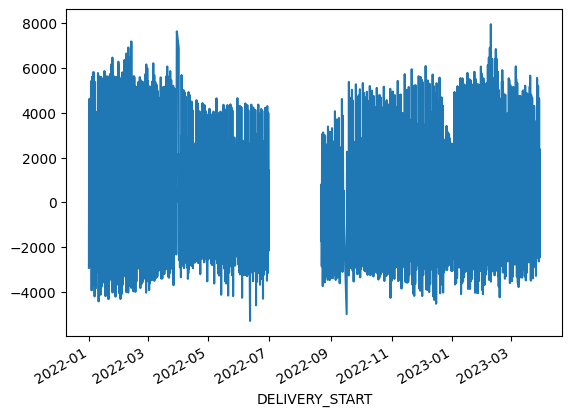

In [17]:
x_train['load_forecast'].diff().plot()

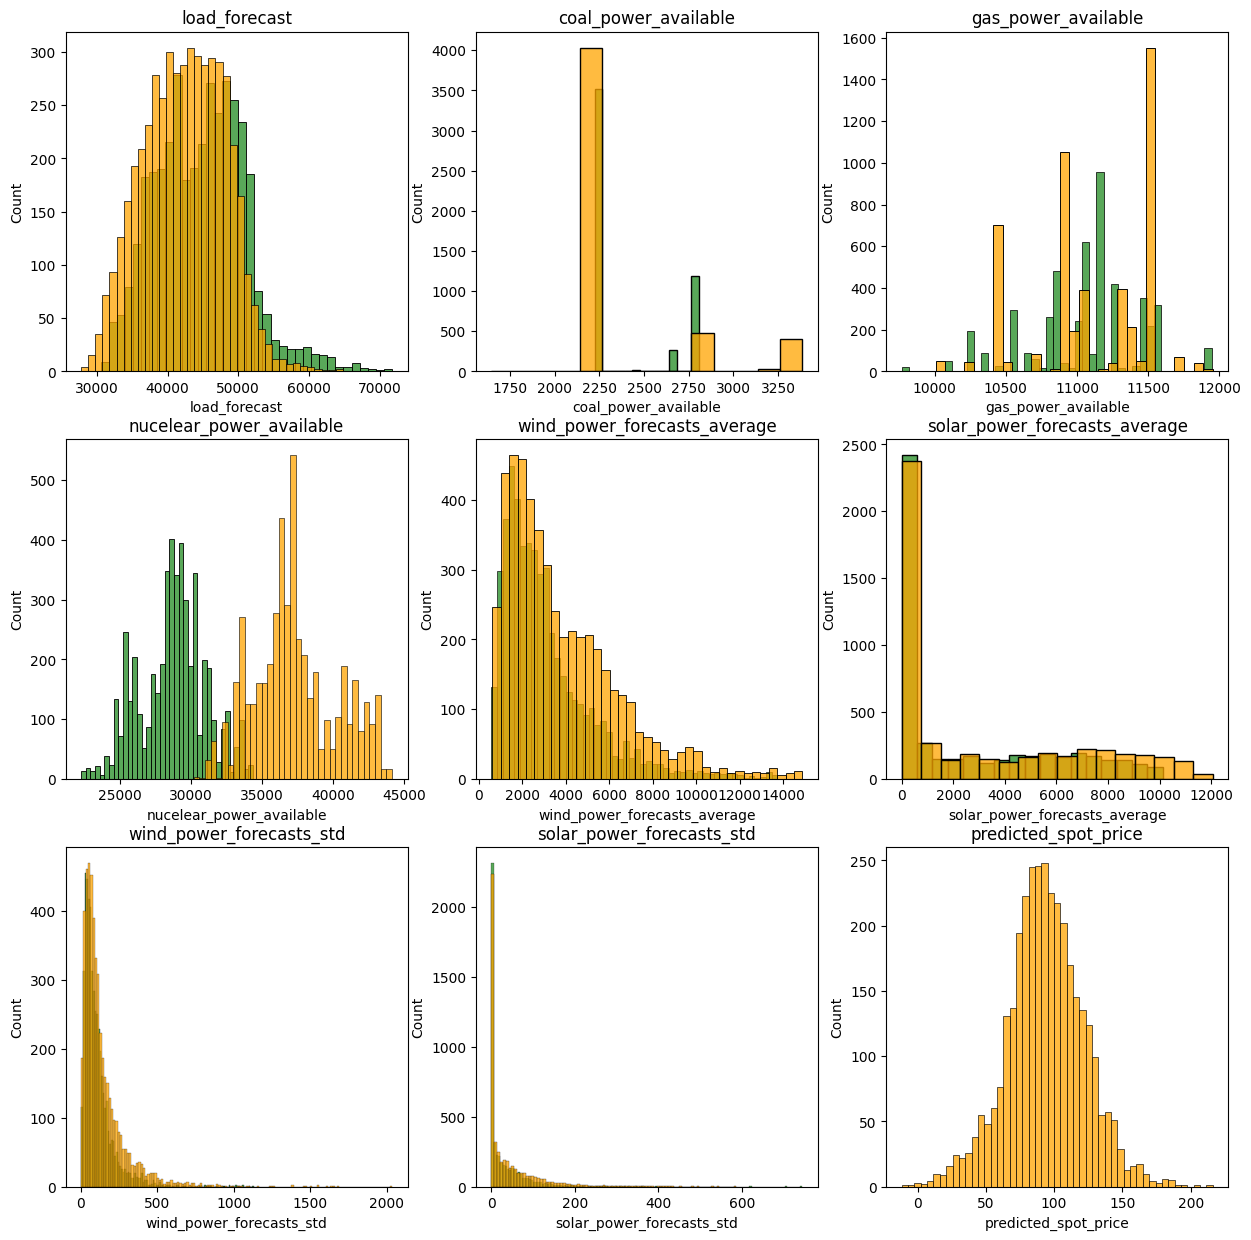

In [25]:
fig, axes = plt.subplots(nrows = 3, ncols = 3)    # axes is 2d array (3x3)
axes = axes.flatten()         # Convert axes to 1d array of length 9
fig.set_size_inches(15, 15)

for ax, col in zip(axes, x_train.columns):
  sns.histplot(x_train['2022-04':'2022-10'][col], ax = ax, color='forestgreen', label='x_train')
  sns.histplot(x_test[col], ax = ax, color='orange', label='x_test', )
  ax.set_title(col)


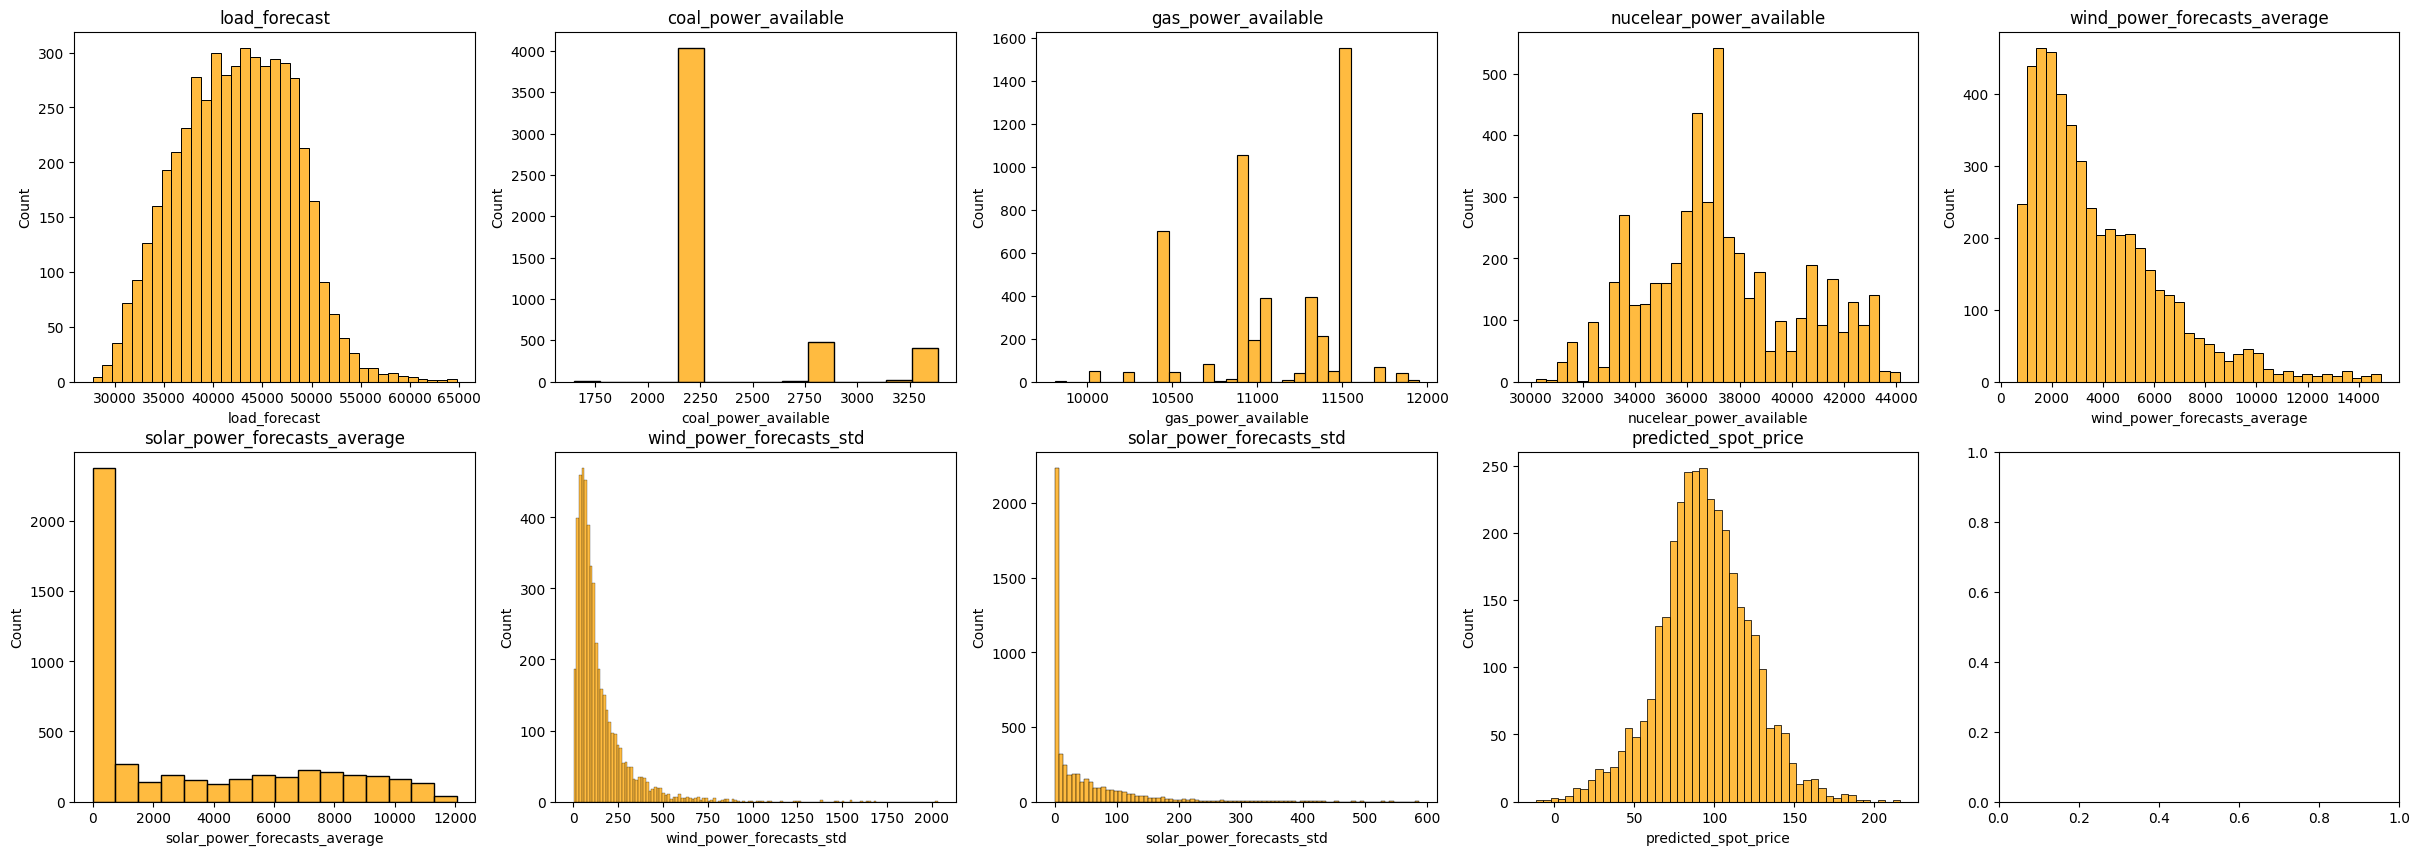

In [16]:
data = pd.concat([x_train,y_train_cls],axis=1)
fig, axes = plt.subplots(nrows = 2, ncols = 5)    # axes is 2d array (3x3)
axes = axes.flatten()         # Convert axes to 1d array of length 9
fig.set_size_inches(30, 10)

for ax, col in zip(axes, x_train.columns):
  sns.histplot(x_test[col], ax = ax, color='orange')
  ax.set_title(col)


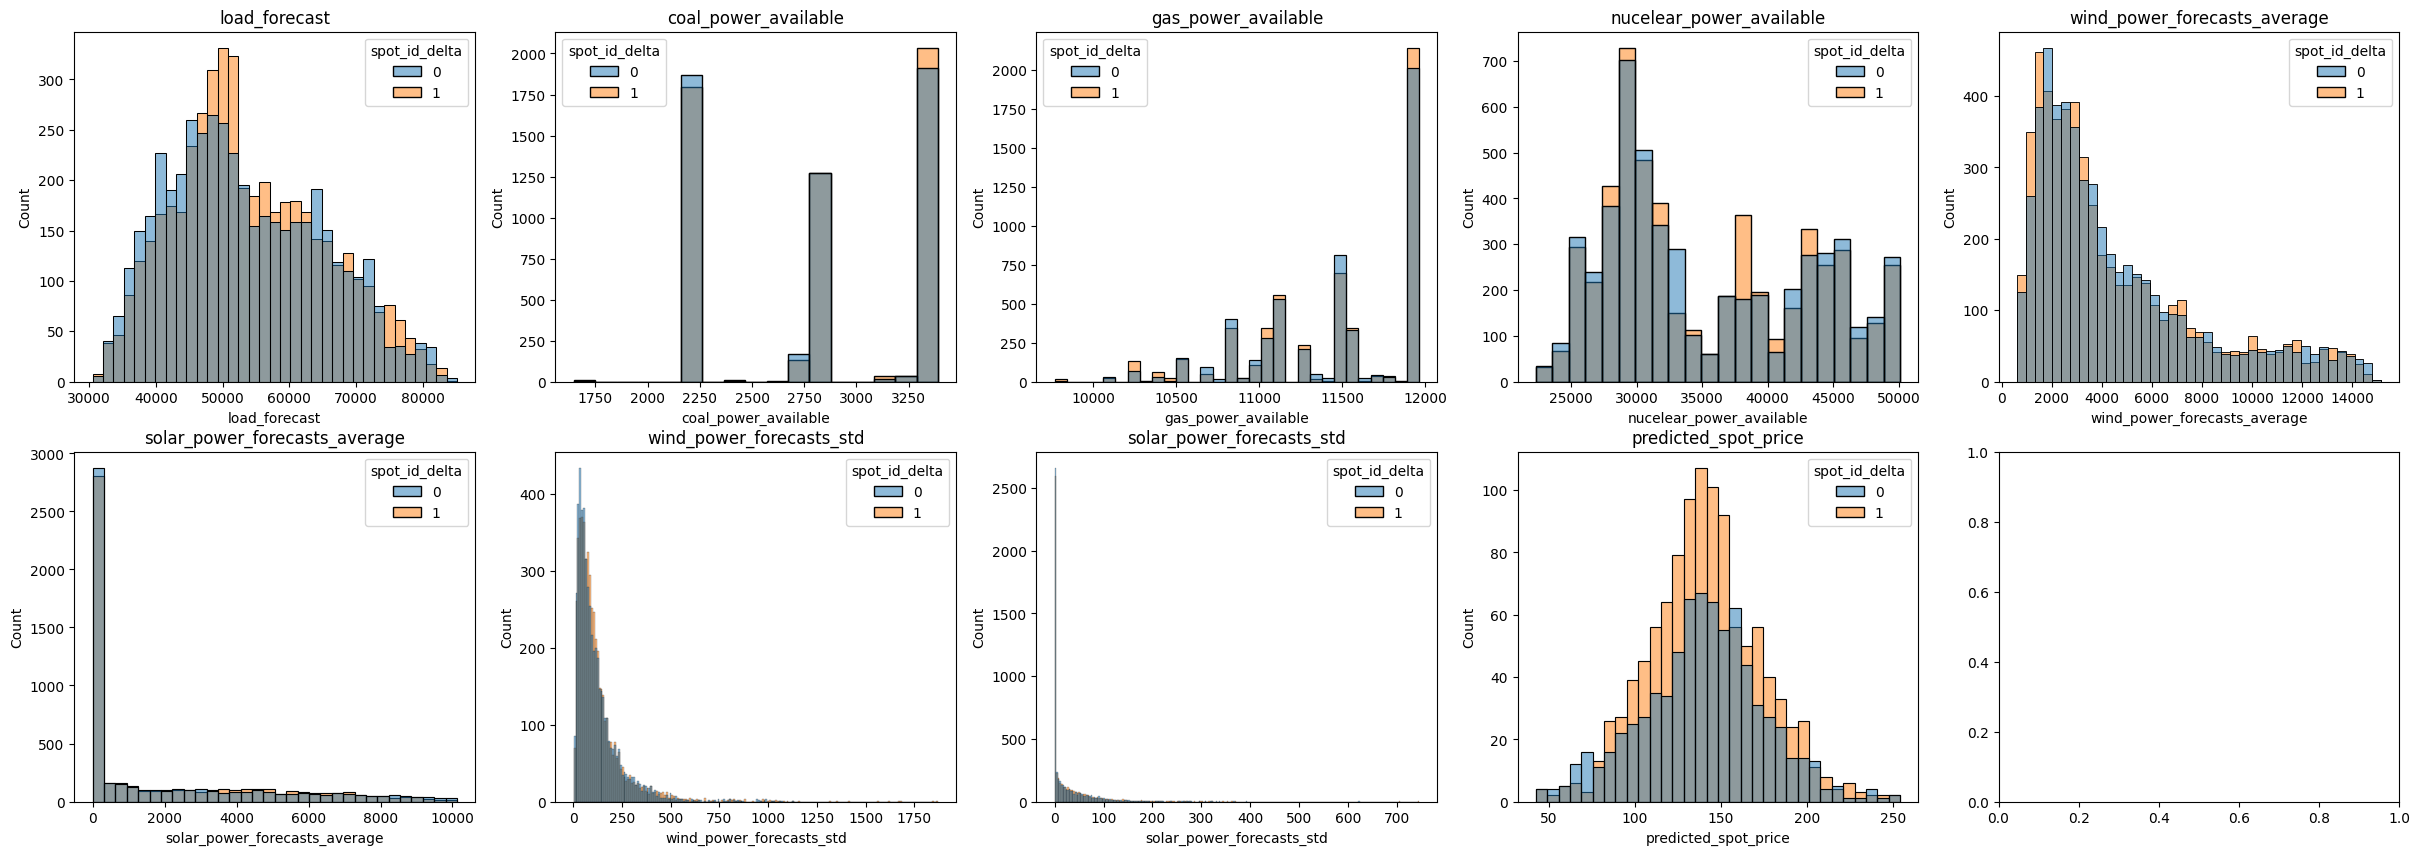

In [14]:
data = pd.concat([x_train,y_train_cls],axis=1)
fig, axes = plt.subplots(nrows = 2, ncols = 5)    # axes is 2d array (3x3)
axes = axes.flatten()         # Convert axes to 1d array of length 9
fig.set_size_inches(30, 10)

for ax, col in zip(axes, x_train.columns):
  sns.histplot(data=data, x=col, ax = ax, color='forestgreen', hue ='spot_id_delta')
  ax.set_title(col)


## Data Preprocessing

* Missing values imputing : take last value

In [11]:
# 1. Temporal Features
x_train['hour_sin'] = np.sin(2 * np.pi * x_train.index.hour / 24)
x_train['hour_cos'] = np.cos(2 * np.pi * x_train.index.hour / 24)

x_train['day_of_week_sin'] = np.sin(2 * np.pi * x_train.index.dayofweek / 7)
x_train['day_of_week_cos'] = np.cos(2 * np.pi * x_train.index.dayofweek / 7)

x_train['month_sin'] = np.sin(2 * np.pi * x_train.index.month / 12)
x_train['month_cos'] = np.cos(2 * np.pi * x_train.index.month / 12)

# 2. Lag Features
lag_variables = ['load_forecast', 'coal_power_available', 'gas_power_available', 
                 'nucelear_power_available', 'wind_power_forecasts_average', 
                 'solar_power_forecasts_average']

for var in lag_variables:
    for i in range(1, 4):  # Lag up to 3 hours
        x_train[f'{var}_lag_{i}'] = x_train[var].shift(i)

# 3. Rolling Statistics
rolling_variables = ['load_forecast', 'wind_power_forecasts_average', 'solar_power_forecasts_average']

for var in rolling_variables:
    x_train[f'{var}_rolling_mean'] = x_train[var].rolling(window=3).mean()
    x_train[f'{var}_rolling_std'] = x_train[var].rolling(window=3).std()

# 4. Interaction Features
x_train['load_wind_interaction'] = x_train['load_forecast'] * x_train['wind_power_forecasts_average']
x_train['load_solar_interaction'] = x_train['load_forecast'] * x_train['solar_power_forecasts_average']

# 5. Price-Demand Ratios
x_train['price_load_ratio'] = x_train['predicted_spot_price'] / x_train['load_forecast']
x_train['price_coal_ratio'] = x_train['predicted_spot_price'] / x_train['coal_power_available']
# Repeat for other power sources

# 6. Volatility Features
x_train['wind_volatility_ratio'] = x_train['wind_power_forecasts_std'] / x_train['wind_power_forecasts_average']
x_train['solar_volatility_ratio'] = x_train['solar_power_forecasts_std'] / x_train['solar_power_forecasts_average']

# ELSE
x_train['deficit'] = x_train['load_forecast'] - x_train['coal_power_available'] - x_train['gas_power_available'] - x_train['nucelear_power_available']


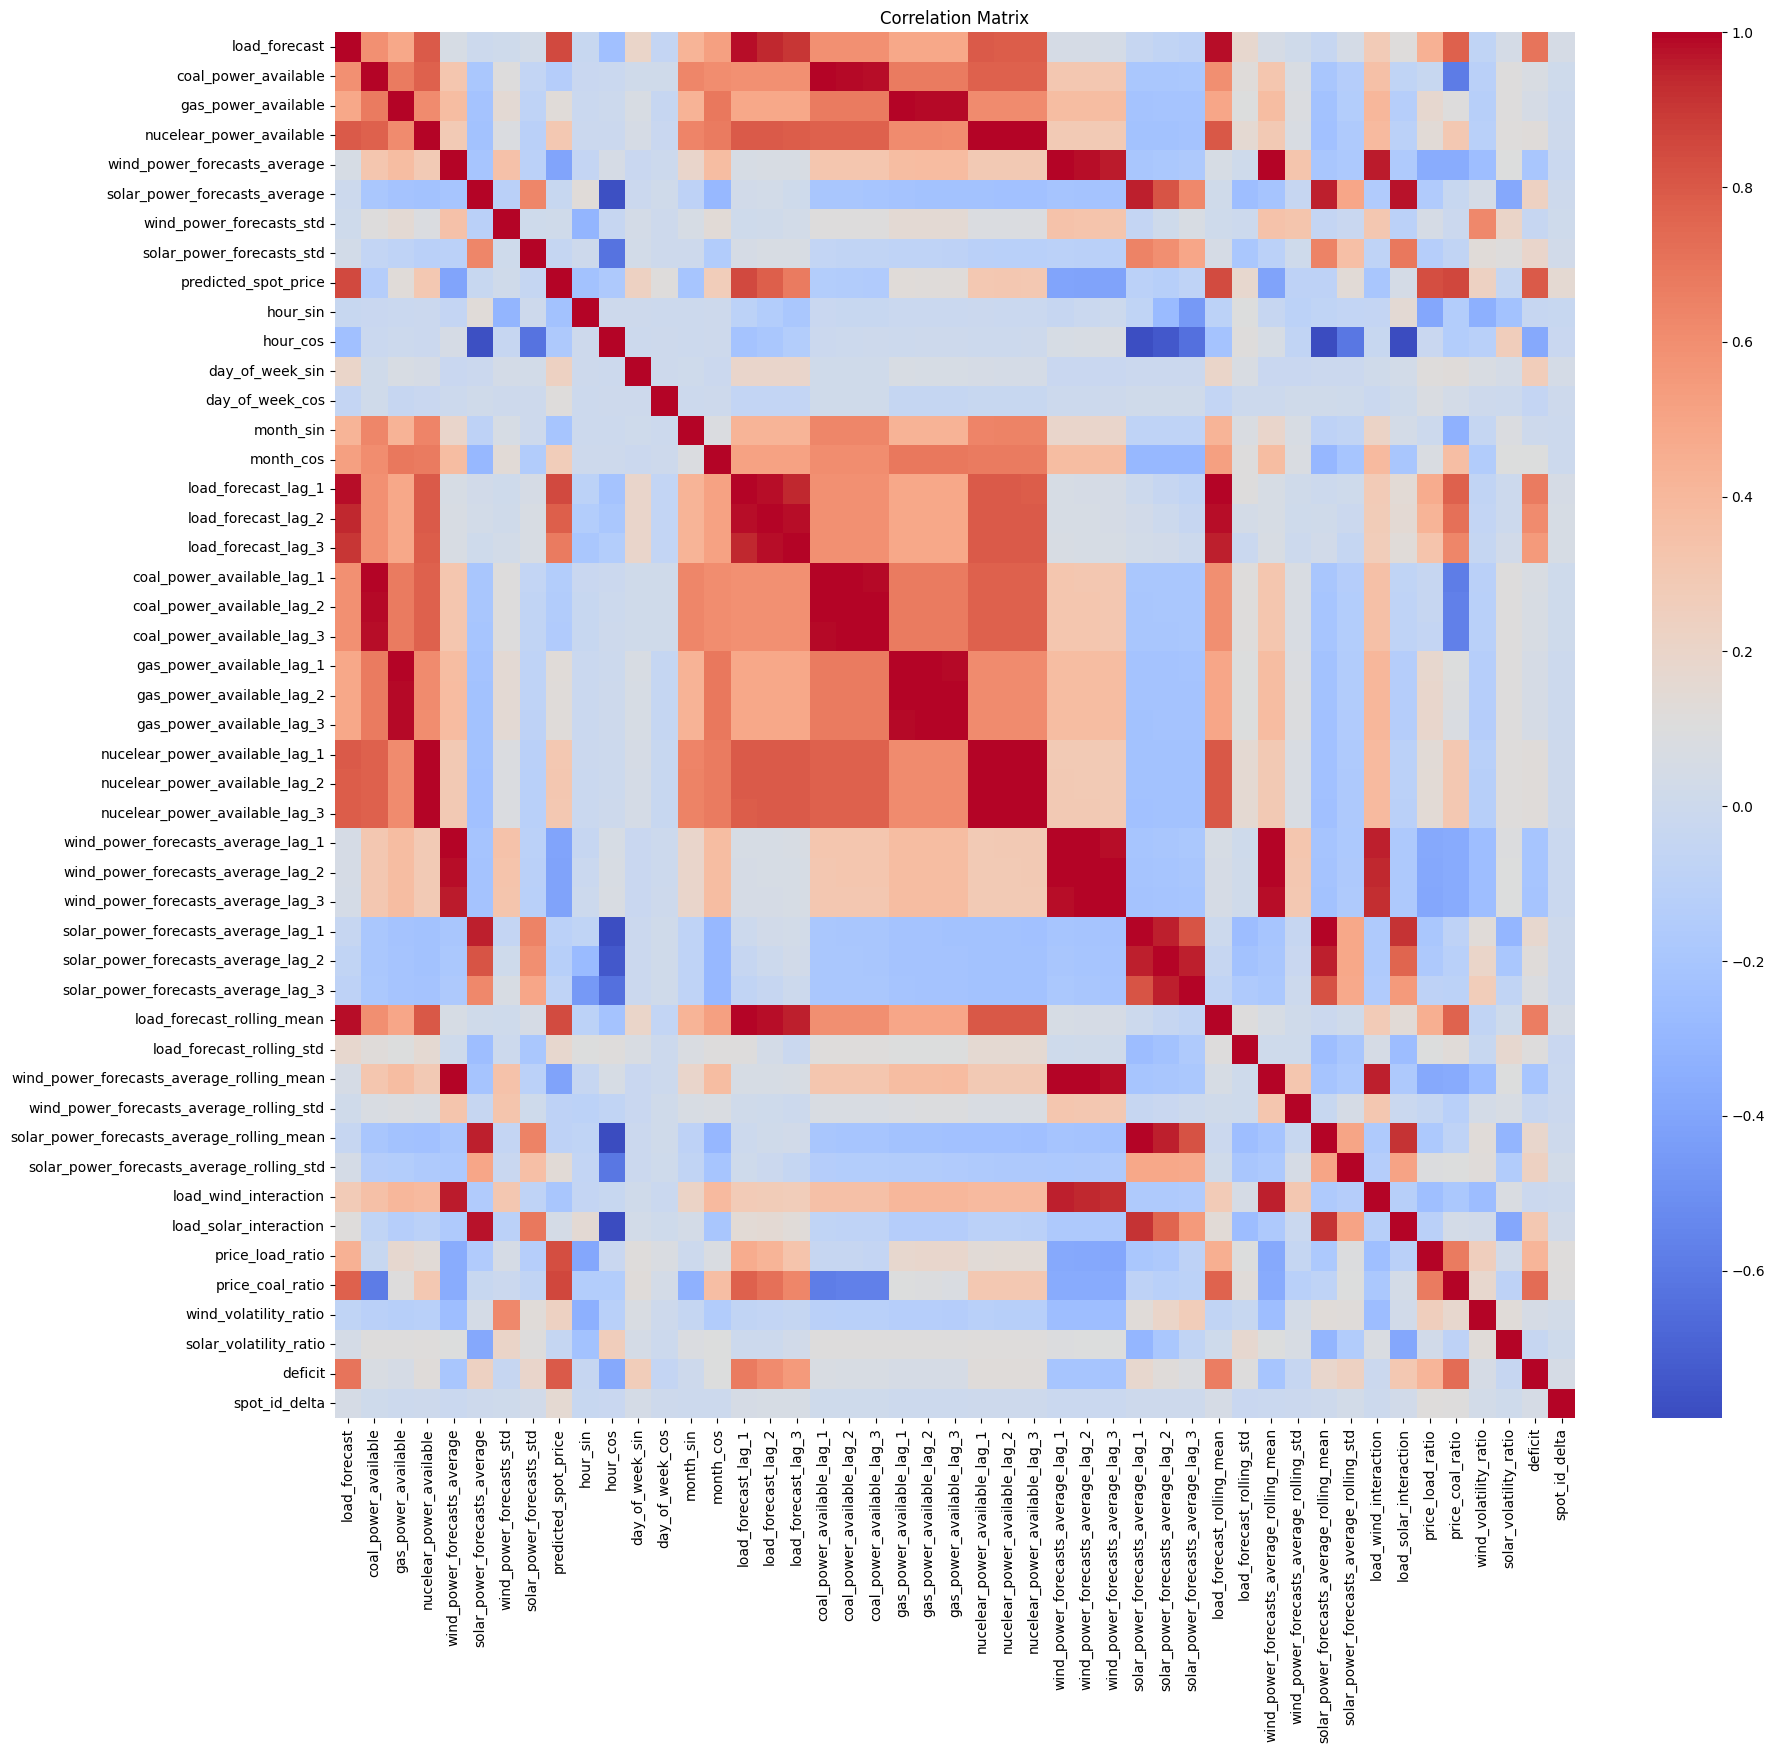

In [12]:
# Combine x_train and y_train into a single DataFrame
features = x_train.columns
data = pd.concat([x_train[features], y_train], axis=1)
# Visualize correlations using seaborn heatmap
plt.figure(figsize=(20, 18))
sns.heatmap(data.corr(), cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()


In [13]:
data = pd.concat([x_train, y_train_cls], axis=1)

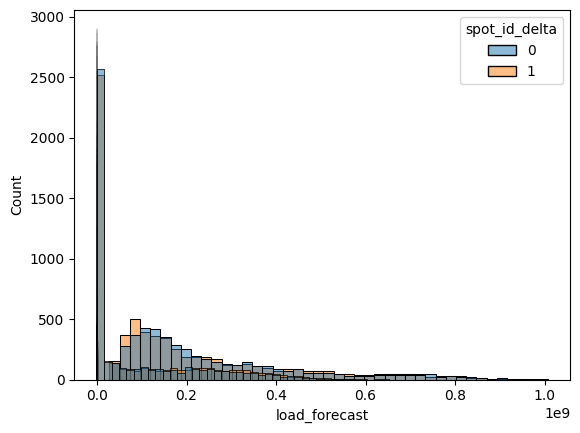

In [14]:
for col in x_train.columns:
    sns.histplot(data,x=col, hue='spot_id_delta')
    # plt.show()

In [33]:
from sklearn.impute import SimpleImputer

# Imputer for numeric features with median strategy
imputer = SimpleImputer(strategy='median')

# Columns to impute
columns_to_impute = ['load_forecast', 'coal_power_available', 'gas_power_available', 
                     'nucelear_power_available', 'wind_power_forecasts_average', 
                     'solar_power_forecasts_average', 'wind_power_forecasts_std', 
                     'solar_power_forecasts_std']

# Imputing missing values in x_train
x_train[columns_to_impute] = imputer.fit_transform(x_train[columns_to_impute])

# Check if there are any missing values left in the columns we aimed to impute
missing_values_after_imputation = x_train[columns_to_impute].isnull().sum()

missing_values_after_imputation

load_forecast                    0
coal_power_available             0
gas_power_available              0
nucelear_power_available         0
wind_power_forecasts_average     0
solar_power_forecasts_average    0
wind_power_forecasts_std         0
solar_power_forecasts_std        0
dtype: int64

## 4. Model 

In [26]:
x_train.drop(['predicted_spot_price'], axis=1, inplace=True)
x_test.drop(['predicted_spot_price'], axis=1, inplace=True)

In [34]:
from src.processing import process_target
from sklearn.svm import SVC


In [35]:
data = pd.concat([x_train,y_train],axis=1)
data_shuffled = data.sample(frac=1)
x_train_shuffled = data_shuffled.drop('spot_id_delta', axis=1)
y_train_shuffled = data_shuffled['spot_id_delta']
y_train_shuffled_cls = process_target(y_train_shuffled, binarize=True)
scaler = RobustScaler()
x_train_shuffled_scaled = scaler.fit_transform(x_train_shuffled)
x_train_shuffled_scaled = pd.DataFrame(x_train_shuffled_scaled, columns=x_train_shuffled.columns)
x_train_scaled = scaler.transform(x_train)
y_train_cls = process_target(y_train, binarize=True)

In [36]:
x_train_, x_val_, y_train_, y_val_ = train_test_split(x_train, y_train, test_size=0.2, random_state=42, shuffle=False)

data_ = pd.concat([x_train_,y_train_],axis=1)
data_shuffled = data_.sample(frac=1)
x_train__shuffled = data_shuffled.drop('spot_id_delta', axis=1)
y_train__shuffled = data_shuffled['spot_id_delta']
y_train__shuffled_cls = process_target(y_train__shuffled, binarize=True)
scaler = RobustScaler()
x_train__shuffled_scaled = scaler.fit_transform(x_train__shuffled)
x_train__shuffled_scaled = pd.DataFrame(x_train__shuffled_scaled, columns=x_train__shuffled.columns)
x_train__scaled = scaler.transform(x_train_)


y_val_cls = process_target(y_val_, binarize=True)
x_val_scaled = scaler.transform(x_val_)
x_val_scaled = pd.DataFrame(x_val_scaled, columns=x_val_.columns)

In [38]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# Initialize KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize the model
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# List to store weighted accuracy for each fold
weighted_accuracies = []
accuracies = []

for train_index, val_index in kf.split(x_train_shuffled):
    # Split data into training and validation sets
    X_train, X_val = x_train.iloc[train_index], x_train.iloc[val_index]
    y_train_cv, y_val_cv = y_train_shuffled_cls.iloc[train_index], y_train_shuffled_cls.iloc[val_index]
    y_train_delta, y_val_delta = y_train_shuffled.iloc[train_index], y_train_shuffled.iloc[val_index]
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    
    # Train the model
    rf_classifier.fit(X_train_scaled, y_train_cv)
    
    # Predict probabilities on validation set
    y_val_pred_proba = rf_classifier.predict_proba(X_val_scaled)[:, 1]
    y_val_pred = rf_classifier.predict(X_val_scaled)
    
    # Calculate weighted accuracy
    binary_pred = (y_val_pred_proba > 0.5).astype(int)
    actual_direction = (y_val_delta > 0).astype(int)
    weights = y_val_delta.abs()
    correct_predictions = (binary_pred == actual_direction).astype(int)
    weighted_accuracy = np.sum(weights * correct_predictions) / np.sum(weights)
    
    accuracies.append(accuracy_score(y_val_cv, y_val_pred))
    weighted_accuracies.append(weighted_accuracy)

# Calculate mean and standard deviation of weighted accuracies
mean_weighted_accuracy = np.mean(weighted_accuracies)
std_weighted_accuracy = np.std(weighted_accuracies)

print("Mean Weighted Accuracy:", mean_weighted_accuracy)
print("Standard Deviation of Weighted Accuracy:", std_weighted_accuracy)
accuracies


Mean Weighted Accuracy: 0.5102477707423375
Standard Deviation of Weighted Accuracy: 0.015935511525653385


[0.49316360207449317,
 0.4926921263554927,
 0.5115511551155115,
 0.48797736916548795,
 0.48514851485148514]

In [43]:
def weighted_accuracy(y_true, y_pred):
    y_true = np.array(y_true).reshape(-1,1)
    y_pred = np.array(y_pred).reshape(-1,1)
    return np.sum(((y_true * y_pred) > 0).astype(int)*np.abs(y_true))/np.sum(np.abs(y_true))

In [52]:
# Create a Random Forest Classifier instance
rf_classifier = RandomForestClassifier(n_estimators=80, random_state=42)

# Train the classifier on the training data
rf_classifier.fit(x_train__shuffled_scaled, y_train__shuffled_cls)

y_train__hat = rf_classifier.predict(x_train__shuffled_scaled)

In [40]:
accuracy_score(y_train__hat, y_train__shuffled_cls)

0.9998821310702499

In [41]:
y_val_hat = rf_classifier.predict(x_val_scaled).reshape(-1,1)
accuracy_score(y_val_hat, y_val_cls)

0.48656294200848654

In [53]:
weighted_accuracy(y_train__shuffled,y_train__hat)

0.9999968233173897

In [54]:
# Create a Random Forest Classifier instance
svc = SVC(kernel='rbf', random_state=42)

# Train the classifier on the training data
svc.fit(x_train__shuffled_scaled, y_train__shuffled_cls)

y_train__hat = svc.predict(x_train__shuffled_scaled)

In [55]:
weighted_accuracy(y_train__shuffled,y_train__hat)

0.6418898356804843

In [58]:
y_val_hat = svc.predict(x_val_scaled).reshape(-1,1)
weighted_accuracy(y_val_, y_val_hat)

0.45052327916018714

In [145]:
y_test_hat = rf_classifier.predict(x_test_scaled)

In [147]:
submission = pd.DataFrame(y_test_hat, columns=['spot_id_delta'], index=x_test.index)

<Axes: >

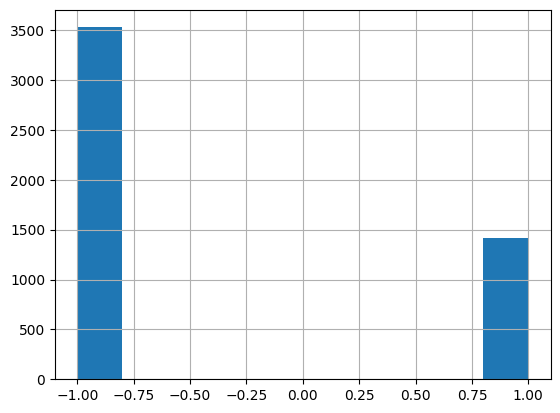

In [149]:
submission['spot_id_delta'].hist()

In [150]:
submission

,spot_id_delta
DELIVERY_START,
2023-04-02 00:00:00+02:00,-1
2023-04-02 01:00:00+02:00,-1
2023-04-02 02:00:00+02:00,-1
2023-04-02 03:00:00+02:00,-1
2023-04-02 04:00:00+02:00,-1
...,...
2023-10-24 19:00:00+02:00,-1
2023-10-24 20:00:00+02:00,-1
2023-10-24 21:00:00+02:00,-1


In [151]:
submission.to_csv('submission.csv')